<h1>Movie Recommendations</h1>
Predict how a user would rate a movie 

Model uses past viewing habits and viewing habits of similar users

Generate Ratings and present the recommedation list

In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os

import json

import boto3
import re
from sagemaker import get_execution_role
import sagemaker

# SDK 2
from sagemaker.deserializers import JSONDeserializer

In [2]:
# RealTimePredictor renamed to Predictor
# https://sagemaker.readthedocs.io/en/stable/v2.html

# Create a predictor and point to an existing endpoint

endpoint_name = 'fm-movie-v4'
predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)

In [3]:
# Custom serializer
def fm_sparse_serializer(data):
    js = {'instances': []}
    for row in data:
        
        column_list = row.tolist()
        value_list = np.ones(len(column_list),dtype=int).tolist()
       
        js['instances'].append({'data':{'features': { 'keys': column_list, 'shape':[dim_movie], 'values': value_list}}})
    return json.dumps(js)

In [4]:
# Specify custom serializer
predictor.serializer.serialize = fm_sparse_serializer
predictor.serializer.content_type = 'application/json'

predictor.deserializer = JSONDeserializer()

In [5]:
# Read Dimension: Number of unique users + Number of unique movies in our dataset
dim_movie = 0

# Update movie dimension - from file used for training 
with open(r'ml-latest-small/movie_dimension.txt','r') as f:
    dim_movie = int(f.read())

In [6]:
# Testing
print(fm_sparse_serializer([np.array([341,1416]),np.array([209,2640]),np.array([164,1346])]))

{"instances": [{"data": {"features": {"keys": [341, 1416], "shape": [10334], "values": [1, 1]}}}, {"data": {"features": {"keys": [209, 2640], "shape": [10334], "values": [1, 1]}}}, {"data": {"features": {"keys": [164, 1346], "shape": [10334], "values": [1, 1]}}}]}


In [7]:
print(dim_movie)

10334


In [8]:
# Test libSVM
# Load the test file in svm format. '5 341:1 1416:1'
test_file = r'ml-latest-small/user_movie_test.svm'

In [9]:
df_test = pd.read_csv(test_file, sep=' ', names=['rating','user_index','movie_index'])

In [10]:
df_test.head()

,rating,user_index,movie_index
0,2.5,426:1,943:1
1,3.0,110:1,10120:1
2,4.0,304:1,1554:1
3,5.0,273:1,867:1
4,2.0,18:1,3373:1


In [11]:
# update column to contain only the one hot encoded index
df_test.user_index = df_test.user_index.map(lambda value: int(value.split(':')[0]))
df_test.movie_index = df_test.movie_index.map(lambda value: int(value.split(':')[0]))

In [12]:
df_test.head()

,rating,user_index,movie_index
0,2.5,426,943
1,3.0,110,10120
2,4.0,304,1554
3,5.0,273,867
4,2.0,18,3373


In [13]:
df_test.shape

(30251, 3)

In [14]:
# For large number of predictions, we can split the input data and
# Query the prediction service.
# array_split is convenient to specify how many splits are needed
def get_predictions(predictor, arr_features):
    predictions = []
    for arr in np.array_split(arr_features,100):        
        if arr.shape[0] > 0:
            print (arr.shape, end=' ')
            result = predictor.predict(arr)
            predictions += [values['score'] for values in result['predictions']]
    return predictions

In [15]:
# %time predictions = get_predictions(predictor_sparse, df_test[['user_index','movie_index']].as_matrix())
%time predictions = get_predictions(predictor, df_test[['user_index','movie_index']].values)

(303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (303, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) (302, 2) CPU times: user 545 ms, sys: 31.9 ms, total: 577 ms
Wall time: 24 s


In [16]:
df_test['predictions'] = predictions

In [17]:
df_test.head()

,rating,user_index,movie_index,predictions
0,2.5,426,943,2.846467
1,3.0,110,10120,3.088131
2,4.0,304,1554,4.013735
3,5.0,273,867,4.138471
4,2.0,18,3373,2.280876


In [18]:
import sklearn.metrics as metrics

In [19]:
print('RMSE: ', metrics.mean_squared_error(df_test.rating, df_test.predictions)**.5)

RMSE:  0.9068520924520447


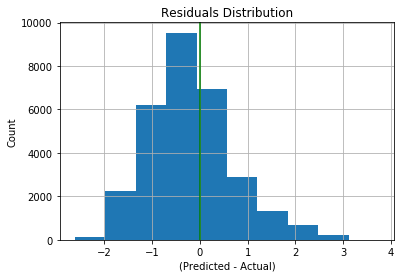

In [20]:
# Training Data Residuals
residuals = (df_test.predictions - df_test.rating)

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')

## Get Prediction for a single user and all movies

In [21]:
# Load the one hot coded index values in svm format
test_file = r'ml-latest-small/one_hot_enc_movies.svm'

In [22]:
df_one_user_test = pd.read_csv(test_file,sep=' ',names=['movieId','user_index','movie_index'])
df_one_user_test.user_index = df_one_user_test.user_index.map(lambda value: int(value.split(':')[0]))
df_one_user_test.movie_index = df_one_user_test.movie_index.map(lambda value: int(value.split(':')[0]))

In [23]:
df_one_user_test.head()

,movieId,user_index,movie_index
0,42011,0,6685
1,428,0,982
2,110,0,707
3,1097,0,1445
4,1073,0,1425


In [24]:
df_one_user_test.shape[0]

9724

In [25]:
%time predictions = get_predictions(predictor, df_one_user_test[['user_index','movie_index']].values)

(98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) CPU times: user 297 ms, sys: 8.98 ms, total: 306 ms
Wall time: 7.41 s


In [26]:
df_one_user_test['rating_predicted'] = predictions

In [27]:
df_one_user_test.head()

,movieId,user_index,movie_index,rating_predicted
0,42011,0,6685,3.430307
1,428,0,982,3.874271
2,110,0,707,4.377944
3,1097,0,1445,4.009686
4,1073,0,1425,4.161342


In [28]:
df_movies = pd.read_csv(r'ml-latest-small/movies_genre.csv')

In [29]:
df_movies.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_one_user_test = df_one_user_test.merge(df_movies, on='movieId')

In [31]:
df_one_user_test.head()

,movieId,user_index,movie_index,rating_predicted,title,genres,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,42011,0,6685,3.430307,Fun with Dick and Jane (2005),Comedy|Crime,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,428,0,982,3.874271,"Bronx Tale, A (1993)",Drama,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,110,0,707,4.377944,Braveheart (1995),Action|Drama|War,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1097,0,1445,4.009686,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1073,0,1425,4.161342,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Recommendation List - ranked by predicted ratings

In [32]:
df_one_user_test.sort_values(['rating_predicted'], ascending=False)[['title','rating_predicted','genres']].head(10)

,title,rating_predicted,genres
162,"Shawshank Redemption, The (1994)",4.666937,Crime|Drama
169,Schindler's List (1993),4.544930,Drama|War
399,Pulp Fiction (1994),4.529284,Comedy|Crime|Drama|Thriller
273,"Usual Suspects, The (1995)",4.511176,Crime|Mystery|Thriller
365,Star Wars: Episode IV - A New Hope (1977),4.501027,Action|Adventure|Sci-Fi
74,"Godfather, The (1972)",4.481360,Crime|Drama
455,Fight Club (1999),4.480318,Action|Crime|Drama|Thriller
136,"Silence of the Lambs, The (1991)",4.474658,Crime|Horror|Thriller
181,"Matrix, The (1999)",4.456688,Action|Sci-Fi|Thriller
234,Star Wars: Episode V - The Empire Strikes Back...,4.448434,Action|Adventure|Sci-Fi


### Action Movies Recommendation List for an user

In [33]:
# Any Action Movies?
df_one_user_test[df_one_user_test.Action == 1].sort_values(['rating_predicted'], ascending=False)[['title','rating_predicted','genres']].head(10)

,title,rating_predicted,genres
365,Star Wars: Episode IV - A New Hope (1977),4.501027,Action|Adventure|Sci-Fi
455,Fight Club (1999),4.480318,Action|Crime|Drama|Thriller
181,"Matrix, The (1999)",4.456688,Action|Sci-Fi|Thriller
234,Star Wars: Episode V - The Empire Strikes Back...,4.448434,Action|Adventure|Sci-Fi
706,Raiders of the Lost Ark (Indiana Jones and the...,4.442193,Action|Adventure
422,"Lord of the Rings: The Return of the King, The...",4.390247,Action|Adventure|Drama|Fantasy
189,"Princess Bride, The (1987)",4.385939,Action|Adventure|Comedy|Fantasy|Romance
408,"Dark Knight, The (2008)",4.385223,Action|Crime|Drama|IMAX
2,Braveheart (1995),4.377944,Action|Drama|War
212,Star Wars: Episode VI - Return of the Jedi (1983),4.367015,Action|Adventure|Sci-Fi


### Comedy Movies Recommendation List for an user

In [34]:
df_one_user_test[df_one_user_test.Comedy == 1].sort_values(['rating_predicted'], ascending=False)[['title','rating_predicted','genres']].head(10)

,title,rating_predicted,genres
399,Pulp Fiction (1994),4.529284,Comedy|Crime|Drama|Thriller
75,Forrest Gump (1994),4.431974,Comedy|Drama|Romance|War
189,"Princess Bride, The (1987)",4.385939,Action|Adventure|Comedy|Fantasy|Romance
467,Fargo (1996),4.367032,Comedy|Crime|Drama|Thriller
906,Dr. Strangelove or: How I Learned to Stop Worr...,4.338914,Comedy|War
52,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.323864,Comedy|Romance
652,Monty Python and the Holy Grail (1975),4.320557,Adventure|Comedy|Fantasy
2014,Snatch (2000),4.292620,Comedy|Crime|Thriller
810,Office Space (1999),4.264610,Comedy|Crime
333,Back to the Future (1985),4.252228,Adventure|Comedy|Sci-Fi


### Drama Movies Recommendation List for an user

In [35]:
# And Drama
df_one_user_test[df_one_user_test.Drama == 1].sort_values(['rating_predicted'], ascending=False)[['title','rating_predicted','genres']].head(10)

,title,rating_predicted,genres
162,"Shawshank Redemption, The (1994)",4.666937,Crime|Drama
169,Schindler's List (1993),4.544930,Drama|War
399,Pulp Fiction (1994),4.529284,Comedy|Crime|Drama|Thriller
74,"Godfather, The (1972)",4.481360,Crime|Drama
455,Fight Club (1999),4.480318,Action|Crime|Drama|Thriller
75,Forrest Gump (1994),4.431974,Comedy|Drama|Romance|War
596,"Godfather: Part II, The (1974)",4.391700,Crime|Drama
422,"Lord of the Rings: The Return of the King, The...",4.390247,Action|Adventure|Drama|Fantasy
408,"Dark Knight, The (2008)",4.385223,Action|Crime|Drama|IMAX
2,Braveheart (1995),4.377944,Action|Drama|War


### Recommendation List for User[333]

In [36]:
df_one_user_test.user_index = 333
predictions = get_predictions(predictor, df_one_user_test[['user_index','movie_index']].values)
df_one_user_test['rating_predicted'] = predictions
df_one_user_test.sort_values(['rating_predicted'], ascending=False)[['title','rating_predicted','genres']].head(10)

(98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) 

,title,rating_predicted,genres
162,"Shawshank Redemption, The (1994)",3.799584,Crime|Drama
169,Schindler's List (1993),3.693170,Drama|War
365,Star Wars: Episode IV - A New Hope (1977),3.665557,Action|Adventure|Sci-Fi
273,"Usual Suspects, The (1995)",3.659945,Crime|Mystery|Thriller
399,Pulp Fiction (1994),3.654926,Comedy|Crime|Drama|Thriller
75,Forrest Gump (1994),3.650747,Comedy|Drama|Romance|War
455,Fight Club (1999),3.635206,Action|Crime|Drama|Thriller
74,"Godfather, The (1972)",3.632123,Crime|Drama
136,"Silence of the Lambs, The (1991)",3.627840,Crime|Horror|Thriller
181,"Matrix, The (1999)",3.621971,Action|Sci-Fi|Thriller


### Recommendation List for User[209]

In [37]:
df_one_user_test.user_index = 209
predictions = get_predictions(predictor, df_one_user_test[['user_index','movie_index']].values)
df_one_user_test['rating_predicted'] = predictions
df_one_user_test.sort_values(['rating_predicted'], ascending=False)[['title','rating_predicted','genres']].head(10)

(98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (98, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) (97, 2) 

,title,rating_predicted,genres
162,"Shawshank Redemption, The (1994)",4.268940,Crime|Drama
169,Schindler's List (1993),4.156101,Drama|War
365,Star Wars: Episode IV - A New Hope (1977),4.126409,Action|Adventure|Sci-Fi
273,"Usual Suspects, The (1995)",4.126077,Crime|Mystery|Thriller
399,Pulp Fiction (1994),4.123901,Comedy|Crime|Drama|Thriller
455,Fight Club (1999),4.096901,Action|Crime|Drama|Thriller
136,"Silence of the Lambs, The (1991)",4.095632,Crime|Horror|Thriller
74,"Godfather, The (1972)",4.095541,Crime|Drama
75,Forrest Gump (1994),4.095396,Comedy|Drama|Romance|War
181,"Matrix, The (1999)",4.084066,Action|Sci-Fi|Thriller


In [39]:
# Delete Endpoint to prevent unnecessary charges
predictor.delete_endpoint()